# File Upload/Download to GitHub from Kaggle Notebooks
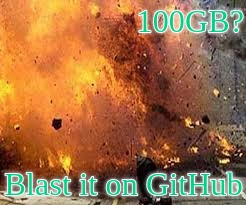
Computer vision challenge such as this, with 100GB sized dataset and a state of the art base model, will hit many developers straight out of the park. Relieing on local bandwidth and computing power will no longer an option. and cloud is the way to go. However cloud charges can be an inhibiting factor to rapidly prototype multiple models on this kind of challenge. 

It will be a blessing to be able to use both kaggle and colab runtimes along with GitHub.
The following solution can be used in current GLD or any other future projects and can certainly add a feather to ones *data engineering* capabilities. This can help in overcoming the limitations of Kaggle/Colab by using GitHub as an intermediate storage. 

> This notebook is an experiment in trying GitHub as one more tool to be considered in data pre/processing activites along with GCP Cloud, and not as a complete alternative.

# Things required to understand this notebook
* Python/Conversions btwn(Numpy, Pandas, strings, tensors)
* GitHub API/Account
* Basic level of Tensorflow usage
* Kaggle/Colab directory structure
* Matplotlib to view images for sanity check
* UNIX/bash commands 

# GitHub Vs GCP
* Data preprocessing activities involves reading the dataset multiple times. This can generate huge data transfer charges from the cloud/GCP. Using GitHub incurs no data transfer and storage chages.
* Training a model involves reading/writing checkpoints, 100's of EPOCHs over dataset, which can again generate considerable cloud storage and data transfer bills.
* However GCP can be an alternative for solutions beyond GitHub's 100GB/repo or 100MB/file limit.
* Competition rules should allow one to upload dataset to public repositories.

# What does this notebook do?
Resize each image to size ~(224,320) preserving the aspect ratio, before uploading to GitHub. After resizing the images, the resultant dataset size is ~15GB, which can easily be accomadated in either kaggle/colab or can be downloaded locally. Either plain images or tar of multiple files can be uploaded

# Motivation: create small dataset
GLD dataset size, 99GB, has been a huge limiting factor in many ways to compete in this image recognition challenge, in a way
* It occupies the whole available user disk space *on kaggle*, which means, no space left out for data manipulation or intermediate data generation related activites.(5GB working directory data limit anyway)
* Not enough Kaggle computing time to validate various ensembling or stacking models
* SSH is not allowed from Kaggle notebook to Colab notebook server(worked briefly and stopped working from next day)
* Can't use *google colab* to train custom models, as the GLD competition dataset size will easily cross the available limits(77GB for CPU/TPU, 37GB for GPU)
* Cannnot edit/remove files in input Dataset. Can only remove entire input dataset, but not individual files, to make space for new edited files.


*Note* Internet switch should be "on" to use this notebook

In [ ]:
import os
import shutil
# Dataset parameters:
INPUT_DIR = os.path.join('..', 'input')

DATASET_DIR = os.path.join(INPUT_DIR, 'landmark-recognition-2020')
TEST_IMAGE_DIR = os.path.join(DATASET_DIR, 'test')
TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, 'train')
TRAIN_LABELMAP_PATH = os.path.join(DATASET_DIR, 'train.csv')
upload_tar_or_plainImages = True #set False to upload plain images

In [ ]:
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf

def load_image_tensor(image_path):
  return tf.convert_to_tensor(
      np.array(PIL.Image.open(image_path).convert('RGB')))

def to_hex(image_id) -> str:
  return '{0:0{1}x}'.format(image_id, 16)

def get_image_path(subset, image_id):
  name = to_hex(image_id)
  return os.path.join(DATASET_DIR, subset, name[0], name[1], name[2],'{}.jpg'.format(name))

In [ ]:
#for file upload, download, decode
import base64
import io
!pip install PyGithub requests
from github import Github
from pprint import pprint

def get_repo(username="uname",password="pass"):
    # authenticate to github
    g = Github(username, password)
    # get the authenticated user
    user = g.get_user()
    repos = user.get_repos()
    !git config --global user.email "XXXXX@gmail.com"
    return(repos[0]) #return the first available repo, change index as per your needs

# Copy CSV files to dataset

In [ ]:
import csv
ImgPerClass_columns = ['imagecount','path']
def write_images_perclass_csv(count_path_dictionary,csv_file):
    try:
        with open(csv_file, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=ImgPerClass_columns)
            writer.writeheader()
            for imgcnt, pathArray in count_path_dictionary.items():
                for imgpath in pathArray[0]:
                    writer.writerow({'path':imgpath, 'imagecount':imgcnt})#path becomes the key as it is unique
            csvfile.close()
    except IOError:
        print("I/O error while creating csv file")
    
def upload_csv_gitGCP(repo,bucket_name,csvfilename):
    try:
        if(upload_to_git):
            with open(csvfilename, 'rb') as csvFile:
                repo.create_file(csvfilename, "initial commit", csvFile.read())
        if(upload_to_gcp):
            upload_blob(bucket_name, csvfilename, csvfilename)
    except:
        print("upload CSV error")

Below, reads entire image list from the dataset and iterate through each image and upload to Git. To check the upload process with just few(100) images, we have taken head(100) into dataframe from csv, before for loop is added. Edit this line, to upload the entire dataset. 

# Caution
Uploading individual images can be a quite time taking. To make this script run faster, tar and upload one single file, for every ~10,000 image files. set upload_tar_or_plainImages to True to upload tar files.


# Preprocess images into groups, for k-fold training later
Create one tar file for each set of images, having same number of images per class/landmark for ex: if landmark 9 & 10, has 2 images each in traning set. All these 4 images will be part of one tar/group file.
This way, we can train model with all classes having only 2 images once, and in next round train model with all classes having 3 images in training set etc ....This will create 430 groups. However we shall combine few sets having less image count per landmark, to restrict groups to around 50
dict = {imgcnt: list of image paths}

In [ ]:
import pandas as pd
import pathlib
from pathlib import Path
from collections import defaultdict
def prepare_imageGroups():
    traincsv = pd.read_csv(DATASET_DIR + '/train.csv')#Remove head to upload whole dataset
    sorteddf = traincsv.groupby('landmark_id').count()
    imgdict = defaultdict(list)
    for landmark,imgcnt in (traincsv.groupby('landmark_id').count()).iterrows():
        landmarks = traincsv.loc[traincsv['landmark_id'] == landmark]
        imgidlist = list(landmarks['id'])
        imgdict[imgcnt['id'].astype(str)].extend(imgidlist)#image count in a class becomes key
    #replace imageid with image path
    for imgcnt, landmark_list in imgdict.items():
        imgdict[imgcnt] = [Path(get_image_path('train',int(landmark,16))) for landmark in landmark_list]
        print("total {} images under all classes having {} images in each class".format(len(imgdict[imgcnt]),imgcnt))
        #some sets have 30k images, divide them into smaller lists
        setsize = len(imgdict[imgcnt])/3000 + 1
        imgdict[imgcnt] = np.array_split(imgdict[imgcnt],setsize)
    return imgdict

# Image resize and save to working/Git directory
If in case of plain images, upload to repository is done below. If uploading tar files, it is done in a create_tarzip function

In [ ]:
import random
import subprocess

def upload_imageset_repo(image_paths,repo):
  #image_paths = [x for x in pathlib.Path(TRAIN_IMAGE_DIR).rglob('*.jpg')]
  for index,image_path in enumerate(image_paths):
    #print(index, "original image:",load_image_tensor(image_path).shape, tf.size(load_image_tensor(image_path)), image_path)
    resized_image = tf.image.resize(load_image_tensor(image_path), (224,320), method='bilinear', preserve_aspect_ratio=True)
    #print("resized image:", resized_image.shape, tf.size(resized_image),"\n")

    np_array = resized_image.numpy()#.eval(session=tf.compat.v1.Session())
    imgarray = Image.fromarray(np_array.astype('uint8'),mode='RGB')
    filepath = os.path.normpath(image_path).replace(DATASET_DIR+"/",'')  
    try:
        directory = os.path.dirname(filepath)
        pathlib.Path(directory).mkdir(parents=True, exist_ok=True) 
        imgarray.save(filepath)
    except:
        print("file save failed: ",filepath)

    if(upload_tar_or_plainImages == False): #False to upload plain images
        try:
            with open(filepath, "rb") as imageFile:
                repo.create_file(filepath, "initial commit", imageFile.read())
                imageFile.close()
            subprocess.call(['rm', filepath])
        except:
            print("Git repo file create exception ", filepath)

# Tarzip and upload to Git or GCP
Tar all the files in this set, upload to Git and clear all the local files. Clearing local files is important to not to exceed working directory limits. Files paths need to be relative paths, before sending to tar. This helps while untar into some other VM or floder path. Use below command to untar and merge all files under same tree structure
> !ls gld/*.gz |xargs -n1 tar -P -xvzf

In [ ]:
import tarfile
upload_to_git = True
upload_to_gcp = False
def create_tarzip(directory_to_tar,tarfilename): 
    #os.system("!find "+directory_to_tar+" -name *.jpg | tar -cvzf "+tarfilename+" -T -")

    def make_tarfile(output_filename, source_dir):
        with tarfile.open(output_filename, "w:gz") as tar:
            tar.add(source_dir, arcname=os.path.basename(source_dir))
    make_tarfile(tarfilename,directory_to_tar)
    try:
        if(upload_to_git):
            with open(tarfilename, "rb") as tarFile:
                repo.create_file(tarfilename, "initial commit", tarFile.read())
                tarFile.close()
        if(upload_to_gcp):
            upload_blob(bucket_name, tarfilename, tarfilename)
        #os.system("!rm -rf "+directory_to_tar+"train/")
    except:
        print("Git repo file create exception ", tarfilename, Path(tarfilename).stat().st_size>>20 )
    subprocess.run(['rm', tarfilename])
    subprocess.call(['rm', '-rf', directory_to_tar+'train'])
    #shutil.rmtree(directory_to_tar+"train")
    
#get all tar files
#untar and mege folders, similar to original dataset
def get_tarzip_from_repo(repo):
    !git clone https://github.com/jkreddy123/gld.git
    basedirpath = "/kaggle/working/gld"
    tar_paths = [x for x in pathlib.Path(basedirpath).rglob('*.tar.gz')]
    for tar_path in tar_paths:
        subprocess.call(['tar', '-xvkf', tar_path]) # use -P if error with /

# Plot images for sanity check
Download few samples images from GitHub and display them using matplotlib for sanity check and correctness. Change samples_to_plot to download/plot desired number of images.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_images(image_paths,samples_to_plot):
    plt.figure()
    f, axarr = plt.subplots(samples_to_plot,1) 

    #plot few samples, by downloading from GiHub
    #image_paths used from the previous cell
    img_paths = random.sample(image_paths,samples_to_plot)
    for index, img_path in enumerate(img_paths):
        filepath = os.path.normpath(img_path).replace(DATASET_DIR+"/",'')
        git_file = repo.get_contents(filepath)
        file_data_string = git_file.content
        image_data = base64.b64decode(file_data_string)
        image = Image.open(io.BytesIO(image_data))

        axarr[index].imshow(image)
    plt.draw()
    plt.show()
    plt.close()

# Deleting all files from Git
Call below function to delete all the files in the repository. It can be used while testing or to remove complete dataset after project is over. Clone repo to local and prepare list of filenames to delete. CD into repository home directory and edit email, username/XXXX, and gitname/gld(twice) before calling

In [ ]:
def delete_files_in_repo(repo):
    !git clone https://github.com/jkreddy123/gld.git
    basedirpath = "/kaggle/working/gld"
    if(upload_tar_or_plainImages == False):
        image_paths = [x for x in pathlib.Path(basedirpath).rglob('*.jpg')]
    else:
        image_paths = [x for x in pathlib.Path(basedirpath).rglob('*.tar.gz')]#*.tar.gz incase of tarballs
    for image_path in image_paths:
      filepath = str(image_path).replace(basedirpath+"/","")#format as per repo path
      print("removing {} from git".format(str(filepath)))
      #os.system("!git rm -f "+filepath)
      try:
        contents = repo.get_contents(filepath)
        repo.delete_file(contents.path, "remove file", contents.sha)
      except:
        print("repo file delete failed: ",filepath)
    #!git commit
    #!git push -f origin master
    shutil.rmtree(basedirpath,ignore_errors=True)

# Upload to GCP storage

In [ ]:
import pandas_profiling as pp
# Set your own project id here
PROJECT_ID = 'mlkaggle-288509'
bucket_name = 'gldv2-train-validate-1580470tfrecords' #should be lower case letters

from google.cloud import storage
storage_client = storage.Client(project=PROJECT_ID)

def create_bucket(dataset_name):
    """Creates a new bucket. https://cloud.google.com/storage/docs/ """
    bucket = storage_client.create_bucket(dataset_name)
    print('Bucket {} created'.format(bucket.name))

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket. https://cloud.google.com/storage/docs/ """
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))
def list_blobs(bucket_name):
    """Lists all the blobs in the bucket. https://cloud.google.com/storage/docs/"""
    blobs = storage_client.list_blobs(bucket_name)
    for blob in blobs:
        print(blob.name)
        
def download_to_kaggle(bucket_name,destination_directory,file_name):
    """Takes the data from your GCS Bucket and puts it into the working directory of your Kaggle notebook"""
    os.makedirs(destination_directory, exist_ok = True)
    blobs = storage_client.list_blobs(bucket_name)
    for blob in blobs:
        full_file_path = os.path.join(destination_directory, blob.name)
        blob.download_to_filename(full_file_path)
 
#from colab use the below lines to upload file to GCP bucket
#from google.colab import auth
#auth.authenticate_user()
#project_id = 'XXXXXXXX'
#bucket_name = 'gldv2-train-validate-1580470tfrecords'
#!gcloud config set project {project_id}
#!gsutil cp  ReducedGLD2020.tar.gz gs://{bucket_name}/ReducedGLD2020.tar.gz

# Main code
*Note:* Replace XXXX with your GitHub account details, for the below code to work.

In [ ]:
#log the time elapsed, useful when running in background/batch
from timeit import default_timer as timer
from datetime import timedelta
start = timer()
repo = get_repo(username="jkreddy123",password="XXXXX")
imagedict = prepare_imageGroups()
for images_per_landmark, image_paths_arr in imagedict.items():
    for index, image_paths in enumerate(image_paths_arr):
        print("uploading {} images of classes having {} images each".format(len(image_paths),images_per_landmark))
        upload_imageset_repo(image_paths,repo)
        create_tarzip("/kaggle/working/",str(images_per_landmark)+"-"+str(index)+"images"+str(len(image_paths))+".tar.gz")
 
if(False):
    csv_file = "images_per_class.csv"
    write_images_perclass_csv(imagedict,csv_file)
    upload_csv_gitGCP(repo,bucket_name,csv_file)
    upload_csv_gitGCP(repo,bucket_name,"train.csv")#take care of input path name
    get_tarzip_from_repo(repo)#get all tarfiles and unzip into same folder structure
    plot_images(image_paths,4)#download the uploaded images and plot
    delete_files_in_repo(repo)#clear local and github repo

end = timer()
print('time taken to upload files to GitHub ', timedelta(seconds=end-start))

Pls Upvote, comment if you find this analysis and code useful in your Machine Learning tasks.
Thanks.